# Exercise List 7

Utilizando o Apache Spark e demais ferramentas correlatas:

1. Defina um grafo direcionado de pelo menos 10 vértices. 
    - O grafo deve representar uma situação do mundo real, sendo que os dados podem ser extraídos de alguma fonte ou artificialmente criados.
2. Calcule o número de triângulos no grafo.
3. Calcule o coeficiente de clustering local dos três vértices com maior grau.
4. Determine os componentes fortemente conectados e os componentes conectados.
    - O quão eles diferem entre si?
5. Determine os clusters do grafo a partir da execução do algoritmo de propagação de rótulos.

**Setup**

In [340]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

conf = SparkConf().setAppName('appName').setMaster('local')
sc = SparkContext.getOrCreate(conf)
spark = SparkSession(sc)

In [341]:
import json

def pretty_print(label, obj):
    print(f'{label}', json.dumps(obj, indent=2))

## 1. Defina um grafo direcionado de pelo menos 10 vértices. 

O grafo abaixo representa a distância real, em quilômetros, entre as cidades demais cidades de Pernambuco (Brasil). As distâncias foram extraídas artificialmente do Google Maps.

**[nx.draw_shell](https://networkx.github.io/documentation/networkx-2.4/tutorial.html#drawing-graphs)**

In [342]:
import networkx as nx

def PlotGraph(edge_list):
    graph = nx.DiGraph()
    if not isinstance(edge_list, type(graph.edges)):
        for row in edge_list.select('src','dst').take(1000):
            graph.add_edge(row['src'], row['dst'])

    plt.subplot(121)
    nx.draw_shell(graph,
                  nlist=[graph.nodes],
                  with_labels=True)

### [NetworkX](networkx.github.io)

In [343]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [344]:
df = pd.read_csv('data/transport/transport-relationships-networkx.csv')

In [345]:
Graphtype = nx.DiGraph()
gnx = nx.from_pandas_edgelist(df,
                              edge_attr='cost',
                              create_using=Graphtype)

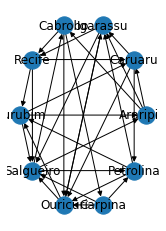

In [346]:
plt.subplot(121)
nx.draw_shell(gnx,
              nlist=[gnx.nodes],
              with_labels=True)

## [Graphframes](https://graphframes.github.io/graphframes/docs/_site/index.html)

In [347]:
from graphframes import *
import pandas as pd

In [348]:
cidades = spark.read.format("csv").option("header", "true").load("data/transport/transport-nodes.csv")
distancias = spark.read.format("csv").option("header", "true").load("data/transport/transport-relationships.csv")

In [349]:
g = GraphFrame(cidades, distancias)

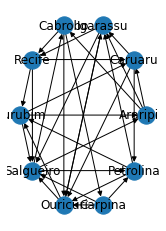

In [350]:
PlotGraph(g.edges)

## 2. Calcule o número de triângulos no grafo.

In [351]:
# def count_triangles(g): 
#     nodes = gnx.nodes()

#     triangles = 0
#     for i in nodes: 
#         for j in nodes: 
#             for k in nodes: 
#                 if(i!=j and i!=k and j!=k and 
#                    g[i][j] and g[j][k] and g[k][i]): 
#                     triangles += 1

#     return count_Triangle / 3

**[nx.simple_cycles](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html)**: elementary cycles in graph.

In [352]:
triangles = [cycle for cycle in nx.simple_cycles(gnx) if len(cycle) == 3]

print("Triangle count: ", len(triangles))
pretty_print('Triangles:', triangles)

Triangle count:  10
Triangles: [
  [
    "Ouricuri",
    "Salgueiro",
    "Petrolina"
  ],
  [
    "Ouricuri",
    "Salgueiro",
    "Cabrobo"
  ],
  [
    "Ouricuri",
    "Surubim",
    "Caruaru"
  ],
  [
    "Igarassu",
    "Recife",
    "Caruaru"
  ],
  [
    "Igarassu",
    "Salgueiro",
    "Petrolina"
  ],
  [
    "Igarassu",
    "Salgueiro",
    "Araripina"
  ],
  [
    "Cabrobo",
    "Recife",
    "Salgueiro"
  ],
  [
    "Cabrobo",
    "Carpina",
    "Salgueiro"
  ],
  [
    "Petrolina",
    "Surubim",
    "Salgueiro"
  ],
  [
    "Petrolina",
    "Surubim",
    "Caruaru"
  ]
]


**[g.triangleCount](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#triangle-count)**: triangles passing through each vertex.

In [353]:
triangles_by_vertex = g.triangleCount()
triangles_by_vertex.select("id", "count").show()

+---------+-----+
|       id|count|
+---------+-----+
|Araripina|    5|
| Igarassu|    9|
|  Carpina|    5|
|Petrolina|   10|
|Salgueiro|   15|
|  Caruaru|    9|
| Ouricuri|   12|
|   Recife|    5|
|  Surubim|    9|
|  Cabrobo|    5|
+---------+-----+



## 3. Calcule o coeficiente de clustering local dos três vértices com maior grau.

In [357]:
gnx.degree(gnx.nodes)

# Top 3 nodes with highest degree: 'Ouricuri', 'Salgueiro', 'Igarassu'.

DiDegreeView({'Araripina': 5, 'Caruaru': 6, 'Igarassu': 7, 'Cabrobo': 5, 'Recife': 5, 'Surubim': 6, 'Salgueiro': 8, 'Ouricuri': 8, 'Carpina': 4, 'Petrolina': 6})

In [358]:
top_3_nodes = ['Ouricuri', 'Salgueiro', 'Igarassu']
print(top_3_nodes)

['Ouricuri', 'Salgueiro', 'Igarassu']


**[networkx.algorithms.cluster.clustering](https://networkx.github.io/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html#networkx-algorithms-cluster-clustering)**

In [359]:
pretty_print('Clustering coefficients:', nx.clustering(gnx,top_3))

Clustering coefficients: {
  "Ouricuri": 0.2777777777777778,
  "Salgueiro": 0.2857142857142857,
  "Igarassu": 0.3
}


### 4. Determine os componentes fortemente conectados e os componentes conectados.

### Componentes fortemente conectados

**[nx.strongly_connected_components](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.strongly_connected_components.html#networkx.algorithms.components.strongly_connected_components)**

In [360]:
print([c for c in nx.strongly_connected_components(gnx)])

[{'Ouricuri', 'Igarassu', 'Cabrobo', 'Petrolina', 'Caruaru', 'Carpina', 'Surubim', 'Araripina', 'Salgueiro', 'Recife'}]


**[g.stronglyConnectedComponents](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#strongly-connected-components)**

In [361]:
scc = g.stronglyConnectedComponents(maxIter=1000)
scc.select("id", "component").orderBy("component").show()

+---------+------------+
|       id|   component|
+---------+------------+
|  Cabrobo|154618822656|
|Araripina|154618822656|
|Petrolina|154618822656|
| Igarassu|154618822656|
|   Recife|154618822656|
|Salgueiro|154618822656|
|  Caruaru|154618822656|
|  Surubim|154618822656|
|  Carpina|154618822656|
| Ouricuri|154618822656|
+---------+------------+



### Componentes conectados

**[nx.connected_components](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#networkx.algorithms.components.connected_components)**: not implemented for `directed` graphs.

**[g.connectedComponents](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#connected-components)**

In [364]:
# we need to set a checkpoint directory in order to use 'algorithm=graphframes' in 'connectedComponents'.
spark.sparkContext.setCheckpointDir('./checkpoints')

In [363]:
cc = g.connectedComponents()
cc.select("id", "component").orderBy("component").show()

+---------+------------+
|       id|   component|
+---------+------------+
|Araripina|154618822656|
|  Caruaru|154618822656|
| Igarassu|154618822656|
|  Cabrobo|154618822656|
|  Carpina|154618822656|
| Ouricuri|154618822656|
|  Surubim|154618822656|
|Petrolina|154618822656|
|Salgueiro|154618822656|
|   Recife|154618822656|
+---------+------------+



**O quão eles diferem entre si?**

Não, são os mesmos! De qualquer forma, vale ressaltar que isso acontece porque podemos chegar em qualquer vertice a usando qualquer outra vertice com ponto inicial, ao mesmo passo que para cada vertice existe um caminho indireto (que passe por outras vertices) de volta à ela.

**Referência: https://people.eecs.berkeley.edu/~vazirani/s99cs170/notes/lec12.pdf**

### 5. Determine os clusters do grafo a partir da execução do algoritmo de propagação de rótulos.

**[nx.asyn_lpa_communities](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.asyn_lpa_communities.html#networkx.algorithms.community.label_propagation.asyn_lpa_communities)**

In [376]:
from networkx.algorithms import community

print([c for c in community.asyn_lpa_communities(gnx)])

[{'Ouricuri', 'Igarassu', 'Cabrobo', 'Petrolina', 'Caruaru', 'Surubim', 'Carpina', 'Araripina', 'Salgueiro', 'Recife'}]


**[g.labelPropagation](https://graphframes.github.io/graphframes/docs/_site/user-guide.html#label-propagation-algorithm-lpa)**

In [378]:
lpa = g.labelPropagation(maxIter=100)
lpa.select("id", "label").show()

+---------+------------+
|       id|       label|
+---------+------------+
|  Cabrobo|867583393792|
|Araripina|652835028992|
|Petrolina|652835028992|
| Igarassu|867583393792|
|   Recife|652835028992|
|Salgueiro|652835028992|
|  Caruaru|867583393792|
|  Surubim|867583393792|
|  Carpina|867583393792|
| Ouricuri|652835028992|
+---------+------------+

